# Extract Regions Tensorflow Object Detection Inference


In [ ]:
!pip install -U --pre tensorflow=="2.2.0"

     |████████████████████████████████| 516.2MB 31kB/s 
     |████████████████████████████████| 3.0MB 33.8MB/s 
     |████████████████████████████████| 460kB 49.3MB/s 
  Found existing installation: tensorboard 2.4.1
    Uninstalling tensorboard-2.4.1:
      Successfully uninstalled tensorboard-2.4.1
  Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tensorflow-estimator-2.4.0
  Found existing installation: tensorflow 2.4.1
    Uninstalling tensorflow-2.4.1:
      Successfully uninstalled tensorflow-2.4.1


## Install Object Detection API

In [ ]:
!git clone --depth 1 https://github.com/tensorflow/models

Cloning into 'models'...
remote: Enumerating objects: 2449, done.
remote: Counting objects: 100% (2449/2449), done.
remote: Compressing objects: 100% (2050/2050), done.
remote: Total 2449 (delta 588), reused 1356 (delta 372), pack-reused 0
Receiving objects: 100% (2449/2449), 30.85 MiB | 31.71 MiB/s, done.
Resolving deltas: 100% (588/588), done.


In [ ]:
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

Processing /content/models/research
  Created wheel for object-detection: filename=object_detection-0.1-cp37-none-any.whl size=1624302 sha256=f2d5cf2cd7650ffc518b620cba0c4275d2c1e262f733354bb1ea0790a41f29f5
  Stored in directory: /tmp/pip-ephem-wheel-cache-s7w0n8dc/wheels/94/49/4b/39b051683087a22ef7e80ec52152a27249d1a644ccf4e442ea
  Created wheel for avro-python3: filename=avro_python3-1.10.1-cp37-none-any.whl size=43735 sha256=16c08f13cea27653f24f4e4532adf67b31f2e974801151a8dcb9196841550863
  Stored in directory: /root/.cache/pip/wheels/65/fe/90/20d6d6d97223d80d20cb390be636619c536edab5658c12bdba
  Created wheel for dill: filename=dill-0.3.1.1-cp37-none-any.whl size=78532 sha256=efad99794ec0d12c2e6fbd8d097cd1bd3b5bef1a011ae19aa8a705f2e372115b
  Stored in directory: /root/.cache/pip/wheels/59/b1/91/f02e76c732915c4015ab4010f3015469866c1eb9b14058d8e7
  Created wheel for future: filename=future-0.18.2-cp37-none-any.whl size=491058 sha256=270fefa66f664f000e849e71bf1cc3adbab4afc28b9dc0d7bd42

ERROR: multiprocess 0.70.11.1 has requirement dill>=0.3.3, but you'll have dill 0.3.1.1 which is incompatible.
ERROR: google-colab 1.0.0 has requirement requests~=2.23.0, but you'll have requests 2.25.1 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: apache-beam 2.28.0 has requirement avro-python3!=1.9.2,<1.10.0,>=1.8.1, but you'll have avro-python3 1.10.1 which is incompatible.


## Imports and setup

In [ ]:
import os
import io
import matplotlib
import matplotlib.pyplot as plt
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from sklearn.metrics.pairwise import euclidean_distances, cosine_similarity
import time
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import tensorflow as tf

from object_detection.utils import label_map_util, config_util
from object_detection.utils import visualization_utils as viz_utils

%matplotlib inline
# import warnings
# warnings.filterwarnings('ignore')   # Suppress Matplotlib warnings

## Connect with drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Load model

In [ ]:
ROOT = 'gdrive/MyDrive/MIA2/landmark_detections'
PATH_TO_SAVED_MODEL = os.path.join(ROOT, 'models', 'saved_model')
PATH_TO_LABELS = os.path.join(ROOT, 'landmarks_label_map.pbtxt')

print('Model path {}'.format(PATH_TO_SAVED_MODEL))
print('Label path {}'.format(PATH_TO_LABELS))

Model path gdrive/MyDrive/MIA2/landmark_detections/models/saved_model
Label path gdrive/MyDrive/MIA2/landmark_detections/landmarks_label_map.pbtxt


In [ ]:
# Load saved model and build the detection function
detect_fn = tf.saved_model.load(PATH_TO_SAVED_MODEL)
print('Model loaded')

Model loaded


## Load label map

In [ ]:
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)
category_index

{1: {'id': 1, 'name': 'mark'}}

## Run detections

In [ ]:
def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: the file path to the image

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  return np.array(Image.open(path))

In [ ]:
IMAGES_FOLDER = os.path.join(ROOT, 'data')
# images_list = os.listdir(IMAGES_FOLDER)
images_list = ['img_{}.jpg'.format(i) for i in [0]]
print('Images folder {}'.format(IMAGES_FOLDER))
print(images_list)

Images folder gdrive/MyDrive/MIA2/landmark_detections/data
['img_0.jpg']


In [ ]:
frames_tolerance = 5
min_score_thresh = 0.5
clusters_dict = {}
clusters_lst = []

for idx, image_name in enumerate(images_list):
  print('{}/{}. Running inference for {}'.format(idx + 1, len(images_list), image_name))
  image_np = load_image_into_numpy_array(os.path.join(IMAGES_FOLDER, image_name))
  input_tensor = tf.convert_to_tensor(image_np)
  input_tensor = input_tensor[tf.newaxis, ...]

  # run detections
  detections = detect_fn(input_tensor)

  num_detections = int(detections.pop('num_detections'))

  detections = {key: value[0, :num_detections].numpy() for key, value in detections.items()}
  detections['num_detections'] = num_detections
  
  # detection_classes should be ints
  detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

  draw_detections = False
  if draw_detections:
    image_np_with_detections = image_np.copy()
    viz_utils.visualize_boxes_and_labels_on_image_array(
        image_np_with_detections,
        detections['detection_boxes'],
        detections['detection_classes'],
        detections['detection_scores'],
        category_index,
        use_normalized_coordinates=True,
        max_boxes_to_draw=20,
        min_score_thresh=min_score_thresh,
        agnostic_mode=False)
    plt.figure(figsize=(16, 20))
    plt.imshow(image_np_with_detections)

  h, w, _ = image_np.shape
  y_ = []

  for idx_, score in enumerate(detections['detection_scores']):
    if score >= min_score_thresh:
      ymin, xmin, ymax, xmax = detections['detection_boxes'][idx_]
      ymin, xmin, ymax, xmax = int(ymin * h), int(xmin * w), int(ymax * h), int(xmax * w)
      y_.append((ymin + ymax) / 2)

  best_n_clusters = None
  cluster_score = None
  try:
    for idx_c, n_clusters in enumerate(range(2, 4)):
      kmeans = KMeans(n_clusters=n_clusters)
      kmeans.fit(np.array(y_).reshape(-1, 1))
      silhouette_avg = silhouette_score(np.array(y_).reshape(-1, 1), kmeans.predict(np.array(y_).reshape(-1, 1)))
      if idx_c == 0 or cluster_score < silhouette_avg:
        best_n_clusters = n_clusters
        cluster_score = silhouette_avg
  except :
    pass
  
  lines = []
  if best_n_clusters is None:
    print('Not possible to create clusters')
  else:
    kmeans = KMeans(n_clusters=best_n_clusters)
    kmeans.fit(np.array(y_).reshape(-1, 1))

    cnt_dict = {}
    counter = np.unique(kmeans.labels_, return_counts=True)
    for key, ctr in zip(counter[0], counter[1]):
      cnt_dict[key] = ctr
    
    for key in cnt_dict.keys():
      if cnt_dict[key] > 1:
        lines.append(int(kmeans.cluster_centers_.reshape(-1)[key]))

  draw_lines = False
  if draw_lines:
    img = Image.fromarray(image_np_with_detections, 'RGB')
    draw = ImageDraw.Draw(img)
    for limit in lines:
      draw.line([(0, limit), (w, limit)], width=10, fill='red')
    plt.figure(figsize=(16, 20))
    plt.imshow(img)
  lines.sort()
  # print('Clusters:', lines)

  clusters_lst.append([image_name, len(lines), lines])
  # analyze only one image
  # break

1/17. Running inference for img_1914.jpg
Not possible to create clusters
2/17. Running inference for img_150.jpg
3/17. Running inference for img_2000.jpg
4/17. Running inference for img_100.jpg
5/17. Running inference for img_333.jpg
6/17. Running inference for img_200.jpg
7/17. Running inference for img_1950.jpg
8/17. Running inference for img_1850.jpg
9/17. Running inference for img_0.jpg
10/17. Running inference for img_300.jpg
11/17. Running inference for img_50.jpg
12/17. Running inference for img_450.jpg
13/17. Running inference for img_1900.jpg
14/17. Running inference for img_350.jpg
15/17. Running inference for img_400.jpg
16/17. Running inference for img_250.jpg
17/17. Running inference for img_57.jpg


In [ ]:
df = pd.DataFrame(clusters_lst)
df.columns=['IMG', 'n_clusters', 'Lines']
df = df.set_index('IMG')
df

,n_clusters,Lines
IMG,,
img_1914.jpg,0,[]
img_150.jpg,3,"[242, 1346, 2086]"
img_2000.jpg,2,"[66, 1427]"
img_100.jpg,2,"[400, 1565]"
img_333.jpg,2,"[209, 1807]"
img_200.jpg,3,"[151, 773, 1750]"
img_1950.jpg,2,"[63, 907]"
img_1850.jpg,2,"[330, 1237]"
img_0.jpg,3,"[287, 1114, 2015]"


In [ ]:
a = df.index.to_series().str.rsplit('.jpg').str[0].str.rsplit('_').str[-1].astype(int).sort_values()
df = df.reindex(index=a.index)
df

,n_clusters,Lines
IMG,,
img_0.jpg,3,"[287, 1114, 2015]"
img_50.jpg,3,"[482, 1421, 2092]"
img_57.jpg,2,"[595, 1548]"
img_100.jpg,2,"[400, 1565]"
img_150.jpg,3,"[242, 1346, 2086]"
img_200.jpg,3,"[151, 773, 1750]"
img_250.jpg,3,"[41, 589, 1680]"
img_300.jpg,2,"[457, 1523]"
img_333.jpg,2,"[209, 1807]"


## Check csv data

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

%matplotlib inline

In [ ]:
ROOT = 'gdrive/MyDrive/MIA2/landmark_detections'
CSV_FILE = os.path.join(ROOT, 'sections_data_003.csv')
df = pd.read_csv(CSV_FILE, index_col='IMG')
df.head()

,n_clusters,Lines
IMG,,
img_0.jpg,3,"[287, 1114, 2035]"
img_1.jpg,3,"[287, 1113, 2036]"
img_2.jpg,3,"[287, 1114, 2036]"
img_3.jpg,3,"[287, 1113, 2036]"
img_4.jpg,3,"[287, 1113, 2036]"


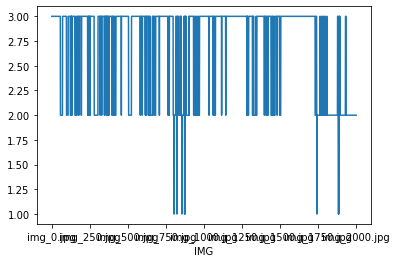

In [ ]:
df['n_clusters'].plot()

In [ ]:
clusters_np = np.array(df['n_clusters'])
d_clusters = np.diff(clusters_np)

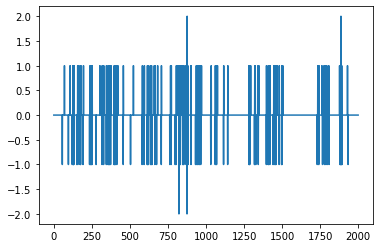

In [ ]:
plt.plot(d_clusters)

In [ ]:
d2_clusters = np.diff(d_clusters)

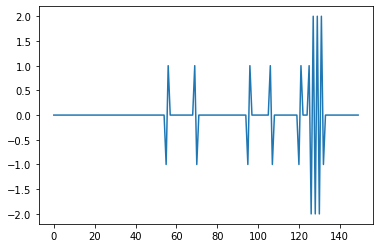

In [ ]:
plt.plot(d2_clusters[:150])

In [ ]:
tmp_array = np.insert(d2_clusters, 0, 0)
tmp_array = np.insert(tmp_array, len(tmp_array), 0)
df['diff2'] = tmp_array

In [ ]:
df

,n_clusters,Lines,diff2
IMG,,,
img_0.jpg,3,"[287, 1114, 2035]",0
img_1.jpg,3,"[287, 1113, 2036]",0
img_2.jpg,3,"[287, 1114, 2036]",0
img_3.jpg,3,"[287, 1113, 2036]",0
img_4.jpg,3,"[287, 1113, 2036]",0
...,...,...,...
img_1996.jpg,2,"[65, 1426]",0
img_1997.jpg,2,"[65, 898]",0
img_1998.jpg,2,"[65, 900]",0


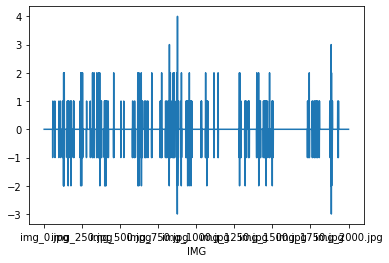

In [ ]:
df['diff2'].plot()

In [ ]:
non_zero_df = df[df['diff2'] != 0]
# non_zero_df

In [ ]:
pd.set_option('display.max_rows', None)
non_zero_df

,n_clusters,Lines,diff2
IMG,,,
img_56.jpg,3,"[591, 1529, 2134]",-1
img_57.jpg,2,"[620, 1548]",1
img_70.jpg,2,"[691, 1817]",1
img_71.jpg,3,"[30, 844, 1838]",-1
img_96.jpg,3,"[377, 1314, 2093]",-1
img_97.jpg,2,"[394, 1461]",1
img_107.jpg,2,"[664, 1677]",1
img_108.jpg,3,"[144, 804, 1720]",-1
img_121.jpg,3,"[503, 1351, 2073]",-1


In [ ]:
non_zero_df.index[abs(non_zero_df['diff2']) == 2]

Index(['img_127.jpg', 'img_128.jpg', 'img_129.jpg', 'img_130.jpg',
       'img_131.jpg', 'img_132.jpg', 'img_158.jpg', 'img_176.jpg',
       'img_240.jpg', 'img_241.jpg', 'img_245.jpg', 'img_246.jpg',
       'img_252.jpg', 'img_318.jpg', 'img_328.jpg', 'img_346.jpg',
       'img_357.jpg', 'img_361.jpg', 'img_365.jpg', 'img_366.jpg',
       'img_398.jpg', 'img_401.jpg', 'img_406.jpg', 'img_457.jpg',
       'img_615.jpg', 'img_616.jpg', 'img_622.jpg', 'img_623.jpg',
       'img_638.jpg', 'img_639.jpg', 'img_707.jpg', 'img_772.jpg',
       'img_822.jpg', 'img_829.jpg', 'img_848.jpg', 'img_855.jpg',
       'img_873.jpg', 'img_877.jpg', 'img_901.jpg', 'img_902.jpg',
       'img_943.jpg', 'img_953.jpg', 'img_954.jpg', 'img_965.jpg',
       'img_1061.jpg', 'img_1069.jpg', 'img_1116.jpg', 'img_1143.jpg',
       'img_1283.jpg', 'img_1284.jpg', 'img_1285.jpg', 'img_1321.jpg',
       'img_1397.jpg', 'img_1409.jpg', 'img_1410.jpg', 'img_1459.jpg',
       'img_1481.jpg', 'img_1499.jpg', 'img_1742.j

In [ ]:
non_zero_df.iloc[0]

n_clusters                    3
Lines         [543, 1496, 2125]
diff2                        -1
Name: img_54.jpg, dtype: object

In [ ]:
non_zero_df.head()

,n_clusters,Lines,diff2
IMG,,,
img_56.jpg,3,"[591, 1529, 2134]",-1
img_57.jpg,2,"[620, 1548]",1
img_70.jpg,2,"[691, 1817]",1
img_71.jpg,3,"[30, 844, 1838]",-1
img_96.jpg,3,"[377, 1314, 2093]",-1


In [ ]:
from PIL import Image, ImageDraw
until_frame = 327
index_ref = list(non_zero_df.index)

sign = 0 # 0 - Negative. 1 - Positive
capture = False
for idx in range(until_frame):
  image_name = 'img_{}.jpg'.format(idx)
  # image_name = 'img_0.jpg'
  # img = Image.open(os.path.join(IMAGES_FOLDER, image_name))  
  if image_name in index_ref:
    if non_zero_df.loc[image_name]['diff2'] == -1:
      n_sign = 0
    elif non_zero_df.loc[image_name]['diff2'] == 1:
      n_sign = 1
    # check sign change
    if sign != n_sign:
      # change
      sign = n_sign
      capture = True if sign == 1 else False
  if capture and df.loc[image_name]['n_clusters'] == 2:
    # mask outside lines
    pass
    # im_a = Image.new("L", img.size, 128)
    # draw = ImageDraw.Draw(im_a)
    # y1, y2 = non_zero_df.loc[image_name]['Lines']
    # draw.rectangle([(0, y1), (img.size[0], y2)], fill=255)
    # img.putalpha(im_a)
  else:
    # mask to all image
    img.putalpha(128)
  # img.save(os.path.join(TARGET_FOLDER, 'img_{}.jpg'.format(idx)))
  # plt.imshow(img)
  # break
  print(image_name, capture)

img_0.jpg False
img_1.jpg False
img_2.jpg False
img_3.jpg False
img_4.jpg False
img_5.jpg False
img_6.jpg False
img_7.jpg False
img_8.jpg False
img_9.jpg False
img_10.jpg False
img_11.jpg False
img_12.jpg False
img_13.jpg False
img_14.jpg False
img_15.jpg False
img_16.jpg False
img_17.jpg False
img_18.jpg False
img_19.jpg False
img_20.jpg False
img_21.jpg False
img_22.jpg False
img_23.jpg False
img_24.jpg False
img_25.jpg False
img_26.jpg False
img_27.jpg False
img_28.jpg False
img_29.jpg False
img_30.jpg False
img_31.jpg False
img_32.jpg False
img_33.jpg False
img_34.jpg False
img_35.jpg False
img_36.jpg False
img_37.jpg False
img_38.jpg False
img_39.jpg False
img_40.jpg False
img_41.jpg False
img_42.jpg False
img_43.jpg False
img_44.jpg False
img_45.jpg False
img_46.jpg False
img_47.jpg False
img_48.jpg False
img_49.jpg False
img_50.jpg False
img_51.jpg False
img_52.jpg False
img_53.jpg False
img_54.jpg False
img_55.jpg False
img_56.jpg False
img_57.jpg True
img_58.jpg True
img_59.jp

In [ ]:
non_zero_df.loc['img_56.jpg']['Lines']

'[591, 1529, 2134]'

In [ ]:
import ast
ast.literal_eval(non_zero_df.loc['img_56.jpg']['Lines'])

[591, 1529, 2134]

In [ ]:
non_zero_df

,n_clusters,Lines,diff2
IMG,,,
img_56.jpg,3,"[591, 1529, 2134]",-1
img_57.jpg,2,"[620, 1548]",1
img_70.jpg,2,"[691, 1817]",1
img_71.jpg,3,"[30, 844, 1838]",-1
img_96.jpg,3,"[377, 1314, 2093]",-1
img_97.jpg,2,"[394, 1461]",1
img_107.jpg,2,"[664, 1677]",1
img_108.jpg,3,"[144, 804, 1720]",-1
img_121.jpg,3,"[503, 1351, 2073]",-1
